<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/o2t_data_preparation_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

This notebook has the goal of reading the data in the original format and put it in a more reasonable format (pandas). So that we could actually work with them.

Version 0.1 - 2.6.2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import walk

In [2]:
#!pip install tensorflow-gpu
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
# root_folder = "/content/drive/My Drive/data/O2T/" # Google Drive Folder
root_folder = "../data/"

## Functions

In [5]:
def read_data_file(name):
    d = {}
    with open(name, encoding="iso8859-1") as f:
        for line in f:
            if ("=" in line):
                (key, val) = line.split('=')
                d[key] = val
    return d

In [6]:
def print_dict(d):
    for key, val in d.items():
        print (key)
        print (val)
        print ("----")

In [7]:
def convert_dictionary(d):
    d_ = {'T': -1, 'O2': -1, 'iter':-1, 'freq':[0], 'data': [0]}
    d_['T'] = int(d['Temperature (°C)'].rstrip())
    d_['O2'] = int(d['Concentration O2Air (%)'].rstrip())
    d_['iter'] = int(d['Iterations'].rstrip())
    d_['freq'] = np.array(re.sub(r'\<.*\>', '', d['Frequency (Hz)']).rstrip().split(","))
    d_['data'] = np.array(re.sub(r'\<.*\>', '', d['Phi Comp (°)']).rstrip().split(",")).reshape(d_['iter'], d_['freq'].shape[0])
    
    d_['freq'] = [d_['freq']]
    d_['data'] = [d_['data']]
    
    p = pd.DataFrame.from_dict(d_)
    return p

In [8]:
def generate_dataframe_from_directory(path):
    df = pd.DataFrame()

    for (dirpath, dirnames, filenames) in walk(path):
        for filename in filenames:
            # Read the files
            if (filename.lower().endswith('txt') and filename.lower().startswith('temp')):
                #print('Reading '+filename)
                d = read_data_file(root_folder+filename)
                p = convert_dictionary(d)
                df = df.append(p)
                
    return df

## Study and test data format

In [9]:
d = read_data_file(root_folder + "Reference.txt")
print_dict(d)

MGI RWA Section Options
2.0.1 %04Y%02m%02d %02H%02M%S%25u*~|.%d*~|.,*~|.%#_13g

----
File
C:\Projekte\LuminescenceAI\RealProbe5mm\Data\Temp_25deg_Conc_100perc.txt

----
Date, Time
26.04.2019, 12:52

----
Temperature (°C)
25

----
Concentration O2Air (%)
100

----
Iterations
1

----
Frequency (Hz)
<50>200,300,400,500,600,700,800,900,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000,7250,7500,7750,8000,8250,8500,8750,9000,9250,9500,9750,10000,11000,12000,13000,14000,15000

----
Phi Comp (°)
<50>-0.354,-0.57,-0.786,-0.99,-1.194,-1.404,-1.602,-1.8,-1.998,-2.502,-3,-3.51,-4.002,-4.506,-5.016,-5.508,-6.012,-6.516,-7.014,-7.512,-8.004,-8.502,-9,-9.492,-9.984,-10.482,-10.974,-11.466,-11.952,-12.444,-12.93,-13.416,-13.902,-14.388,-14.874,-15.36,-15.84,-16.32,-16.8,-17.274,-17.754,-18.234,-18.702,-19.176,-19.644,-21.522,-23.37,-25.2,-26.994,-28.776

----
R (V)
<50>0.298922,0.298952,0.298983,0.298922,0.298861,0.29883

In [10]:
d = read_data_file(root_folder + "Temp_5deg_Conc_0perc.txt")
d = convert_dictionary(d)

## Load the reference file

We load now the reference file. This needs to be subtracted by all other measurements.

In [11]:
ref = read_data_file(root_folder + "Reference.txt")
ref = convert_dictionary(ref)
ref_data = ref.data[0].astype(np.float)

# Loop over files in the directory

In [92]:
df = generate_dataframe_from_directory(root_folder)

In [93]:
df.head()

,T,O2,iter,freq,data
0,20,35,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-2.424, -3.642, -4.83, -6.036, -7.236, -8.4,..."
0,20,25,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-2.706, -4.05, -5.388, -6.726, -8.034, -9.33..."
0,25,10,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-3.288, -4.926, -6.552, -8.166, -9.762, -11...."
0,10,95,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-1.776, -2.682, -3.564, -4.452, -5.334, -6.1..."
0,10,85,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-1.86, -2.808, -3.732, -4.662, -5.58, -6.48,..."


In [94]:
df.data[0].iloc[0]

df.data[0]

0    [[-2.424, -3.642, -4.83, -6.036, -7.236, -8.4,...
0    [[-2.706, -4.05, -5.388, -6.726, -8.034, -9.33...
0    [[-3.288, -4.926, -6.552, -8.166, -9.762, -11....
0    [[-1.776, -2.682, -3.564, -4.452, -5.334, -6.1...
0    [[-1.86, -2.808, -3.732, -4.662, -5.58, -6.48,...
                           ...                        
0    [[-1.83, -2.736, -3.642, -4.554, -5.442, -6.33...
0    [[-2.808, -4.23, -5.622, -7.014, -8.388, -9.74...
0    [[-2.88, -4.314, -5.748, -7.158, -8.562, -9.94...
0    [[-2.556, -3.828, -5.088, -6.354, -7.602, -8.8...
0    [[-3.006, -4.512, -6, -7.476, -8.934, -10.38, ...
Name: data, Length: 189, dtype: object

# Creation of the dataframe with just values for [O2]=0 % air

__note__: we will average the 20 measurements into one and use that to divide the other data.

In [15]:
df_zero = df[df['O2'] == 0]
df_zero

,T,O2,iter,freq,data
0,30,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.338, -6.492, -8.616, -10.716, -12.78, -14..."
0,35,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.242, -6.354, -8.43, -10.5, -12.516, -14.5..."
0,5,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.83, -7.23, -9.594, -11.922, -14.202, -16...."
0,15,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.626, -6.918, -9.174, -11.406, -13.59, -15..."
0,10,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.728, -7.062, -9.372, -11.646, -13.884, -1..."
0,20,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.53, -6.768, -8.988, -11.172, -13.32, -15...."
0,25,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.428, -6.63, -8.796, -10.95, -13.056, -15...."
0,45,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.05, -6.078, -8.07, -10.038, -11.982, -13...."
0,40,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.146, -6.21, -8.25, -10.26, -12.252, -14.1..."


Now we can average for each values of $T$ the 20 measurements contained into `data`

In [16]:
average_data = []
for index, row in df_zero.iterrows():
  #print(np.array(row['data']))
  avg_ = np.mean(np.array(row['data']).astype(np.float), axis = 0)
  #print(avg_)
  average_data.append(avg_)

df_zero['average'] = average_data

/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
df_zero.head()

,T,O2,iter,freq,data,average
0,30,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.338, -6.492, -8.616, -10.716, -12.78, -14...","[-4.3397999999999985, -6.492600000000001, -8.6..."
0,35,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.242, -6.354, -8.43, -10.5, -12.516, -14.5...","[-4.2456000000000005, -6.354, -8.4354000000000..."
0,5,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.83, -7.23, -9.594, -11.922, -14.202, -16....","[-4.836899999999999, -7.229700000000001, -9.59..."
0,15,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.626, -6.918, -9.174, -11.406, -13.59, -15...","[-4.6248000000000005, -6.916800000000004, -9.1..."
0,10,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.728, -7.062, -9.372, -11.646, -13.884, -1...","[-4.724099999999998, -7.064099999999999, -9.37..."


# Transformation of the dataframe

Now we need to create two numpy arrays. One with the "expected values" containing $T$ and $O2$ and one with all the measurements.

We have a certain amount of iterations contained in the column `iter` therefore we will need do duplicate the values of $T$ and $O2$ `iter` times.

In [18]:
x = df.iloc[0]['freq'].astype(np.float)
x

array([  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.])

In [19]:
targets = []
train_data = []
for index, row in df.iterrows():
  list_ = [[row['T'], row['O2']]]*row['iter']
  #print(np.array(list_).shape)
  targets.extend(list_)

  # Then we need to create a list with all the measurements. 
  # There are row['iter'] of them.
  data_ = row['data'] # Shape (20,50)
  assert (data_.shape) == (row['iter'], len(row.freq)), "Size mismatch."
  
  for i in range(0, row['iter']):
    train_data.append(data_[i])

train_data_np = np.array(train_data).astype(np.float)
train_targets_np = np.array(targets).astype(np.float)

print(train_data_np.shape)
print(train_targets_np.shape)

(3780, 50)
(3780, 2)


In [20]:
# quick check to see how the data looks like. So far so good.
train_data_np[0]

array([ -2.424,  -3.642,  -4.83 ,  -6.036,  -7.236,  -8.4  ,  -9.564,
       -10.716, -11.856, -14.598, -17.25 , -19.77 , -22.176, -24.45 ,
       -26.604, -28.662, -30.594, -32.436, -34.176, -35.826, -37.404,
       -38.892, -40.308, -41.664, -42.942, -44.16 , -45.33 , -46.446,
       -47.502, -48.522, -49.494, -50.424, -51.318, -52.164, -52.998,
       -53.778, -54.528, -55.266, -55.956, -56.634, -57.276, -57.894,
       -58.506, -59.088, -59.652, -61.704, -63.51 , -65.1  , -66.522,
       -67.776])

In [21]:
df_1

NameError: name 'df_1' is not defined

# Plot 1 for different values of O2 and T = 25

In [22]:
df_1 = df[(df['O2'] == 0) & (df['T'] == 25)].data[0][0].astype(np.float)
df_2 = df[(df['O2'] == 20) & (df['T'] == 25)].data[0][0].astype(np.float)
df_3 = df[(df['O2'] == 40) & (df['T'] == 25)].data[0][0].astype(np.float)
df_4 = df[(df['O2'] == 60) & (df['T'] == 25)].data[0][0].astype(np.float)
df_5 = df[(df['O2'] == 80) & (df['T'] == 25)].data[0][0].astype(np.float)
df_6 = df[(df['O2'] == 100) & (df['T'] == 25)].data[0][0].astype(np.float)
#df_1_data = df_1.data[0][0].astype(np.float)

W0117 14:01:08.452209 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0117 14:01:08.452925 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


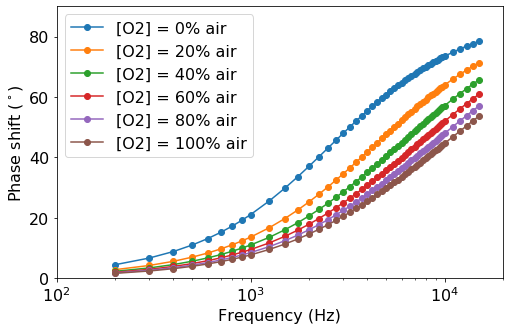

In [23]:
fig = plt.figure(figsize = (8,5))
plt.plot(x,-df_1, marker= 'o', label = '[O2] = 0% air')
plt.plot(x,-df_2, marker= 'o', label = '[O2] = 20% air')
plt.plot(x,-df_3, marker= 'o', label = '[O2] = 40% air')
plt.plot(x,-df_4, marker= 'o', label = '[O2] = 60% air')
plt.plot(x,-df_5, marker= 'o', label = '[O2] = 80% air')
plt.plot(x,-df_6, marker= 'o', label = '[O2] = 100% air')
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16)
plt.ylim(0, 90)
plt.xlim(100, 20000)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
plt.xscale('log')
fig.savefig('../paper/expdata1.eps')

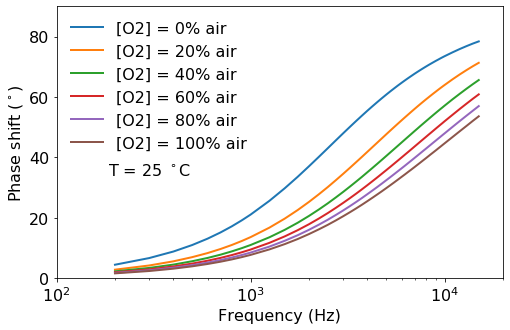

In [306]:
fig = plt.figure(figsize = (8,5))
plt.plot(x,-df_1, label = '[O2] = 0% air', linewidth = 2)
plt.plot(x,-df_2, label = '[O2] = 20% air', linewidth = 2)
plt.plot(x,-df_3, label = '[O2] = 40% air', linewidth = 2)
plt.plot(x,-df_4, label = '[O2] = 60% air', linewidth = 2)
plt.plot(x,-df_5, label = '[O2] = 80% air', linewidth = 2)
plt.plot(x,-df_6, label = '[O2] = 100% air', linewidth = 2)
plt.tick_params(labelsize=16)
plt.text (185,34, 'T = 25 $^\circ$C', fontsize = 16)
plt.legend(fontsize = 16, frameon = False)
plt.ylim(0, 90)
plt.xlim(100, 20000)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
plt.xscale('log')
fig.savefig('../paper/expdata1.eps')

# Plot 2 for different values of T and O2 = 100%

In [29]:
OXY = 20

df_21 = df[(df['O2'] == OXY) & (df['T'] == 5)].data[0][0].astype(np.float)
df_22 = df[(df['O2'] == OXY) & (df['T'] == 15)].data[0][0].astype(np.float)
df_23 = df[(df['O2'] == OXY) & (df['T'] == 25)].data[0][0].astype(np.float)
df_24 = df[(df['O2'] == OXY) & (df['T'] == 35)].data[0][0].astype(np.float)
df_25 = df[(df['O2'] == OXY) & (df['T'] == 45)].data[0][0].astype(np.float)
#df_1_data = df_1.data[0][0].astype(np.float)

W0117 14:02:45.396734 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0117 14:02:45.397303 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


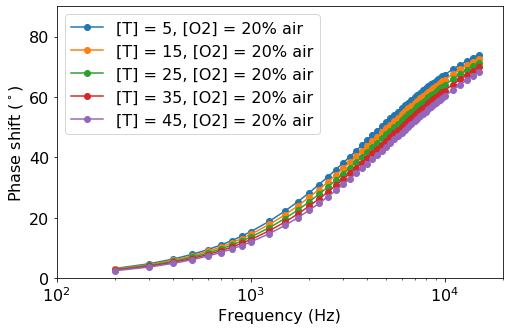

In [30]:
fig = plt.figure(figsize = (8,5))
plt.plot(x,-df_21, marker= 'o', label = '[T] = 5, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_22, marker= 'o', label = '[T] = 15, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_23, marker= 'o', label = '[T] = 25, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_24, marker= 'o', label = '[T] = 35, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_25, marker= 'o', label = '[T] = 45, [O2] = '+str(OXY)+'% air')
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16)
plt.ylim(0, 90)
plt.xlim(100, 20000)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
plt.xscale('log')
fig.savefig('../paper/expdata2.eps')

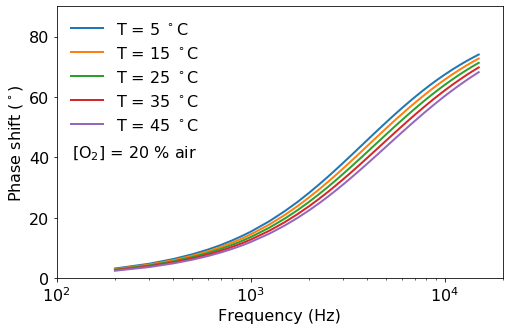

In [305]:
fig = plt.figure(figsize = (8,5))
plt.plot(x,-df_21, label = 'T = 5 $^\circ$C', linewidth = 2)
plt.plot(x,-df_22, label = 'T = 15 $^\circ$C', linewidth = 2)
plt.plot(x,-df_23, label = 'T = 25 $^\circ$C', linewidth = 2)
plt.plot(x,-df_24, label = 'T = 35 $^\circ$C', linewidth = 2)
plt.plot(x,-df_25, label = 'T = 45 $^\circ$C', linewidth = 2)
plt.text (120,40, '[O$_2$] = 20 % air', fontsize = 16)
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16, frameon=False)
plt.ylim(0, 90)
plt.xlim(100, 20000)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
plt.xscale('log')
fig.savefig('../paper/expdata2.eps')
fig.savefig('../paper/expdata2.svg')

# Plot paper number 3 

In [168]:
x[28] # f = 6000 Hz

6000.0

In [101]:
listT = df['T'].unique()
print(listT)

[20 25 10 30 35 15 40 45  5]


In [233]:
df3 = pd.DataFrame({'T': df['T'].unique(), 'data': None, 'O2x': None})
for T_ in df3['T']:
    O2x = df[df['T'] == T_][['O2','data']].reset_index()['O2'].tolist()
    phasey = []
    for o2 in O2x:
        tmp = - df[(df['T'] == T_) & (df['O2'] == o2)]['data'].reset_index().iloc[0].tolist()[1][0][28].astype(np.float)
        phasey.append(tmp)
    dftmp = pd.DataFrame({'data':[phasey]})
    dftmp2 = pd.DataFrame({'O2x':[O2x]})
        
    df3.loc[df3["T"] == T_, 'data'] = [dftmp['data']]
    df3.loc[df3["T"] == T_, 'O2x'] = [dftmp2['O2x']]
    
print(df3)

    T                                               data  \
0  20  0    [47.502, 51.108, 35.22, 36.624, 41.01, 39...   
1  25  0    [57.378, 41.01, 43.476, 60.414, 50.076, 4...   
2  10  0    [37.14, 38.568, 49.596, 53.136, 36.396, 4...   
3  30  0    [49.008, 45.36, 34.65, 33.294, 37.032, 38...   
4  35  0    [55.56, 41.388, 38.97, 44.322, 47.982, 32...   
5  15  0    [35.412, 59.148, 43.128, 45.606, 37.572, ...   
6  40  0    [35.1, 36.954, 57.966, 32.772, 31.47, 46....   
7  45  0    [39.354, 36.99, 29.946, 57.138, 53.694, 3...   
8   5  0    [47.652, 45.168, 60.972, 44.064, 42.084, ...   

                                                 O2x  
0  0    [35, 25, 95, 85, 60, 70, 10, 5, 45, 55, 5...  
1  0    [10, 55, 45, 5, 25, 35, 85, 95, 70, 60, 6...  
2  0    [95, 85, 35, 25, 100, 60, 70, 10, 5, 45, ...  
3  0    [25, 35, 85, 95, 70, 60, 10, 0, 55, 45, 4...  
4  0    [10, 45, 55, 35, 25, 95, 85, 0, 60, 70, 7...  
5  0    [100, 10, 55, 45, 85, 95, 25, 35, 70, 60,...  
6  0    [70, 6

In [258]:
df3['T'].iloc[0]

20

W0120 21:01:13.816593 4624096704 legend.py:1282] No handles with labels found to put in legend.


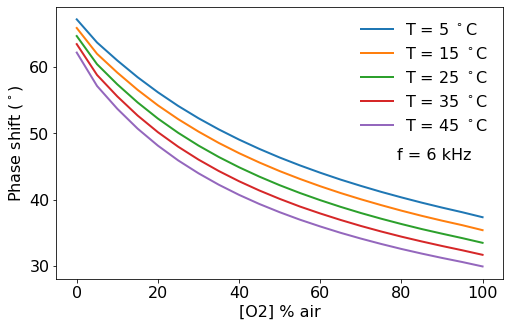

In [319]:
fig = plt.figure(figsize=(8,5))
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16, frameon=False)
plt.xlabel('[O2] % air', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
#plt.ylim(0,90)
df3sorted = df3.sort_values('T')
for i in np.arange(0,df3.shape[0],2):
    xx,yy = zip(*sorted(zip(df3sorted.iloc[i]['O2x'][0],df3sorted.iloc[i]['data'][0])))
    plt.plot(xx,yy, linewidth = 2, label = 'T = ' + str(df3sorted['T'].iloc[i]) + ' $^\circ$C')
plt.legend(fontsize = 16, frameon=False)
plt.text (79,46, 'f = 6 kHz', fontsize = 16)
plt.show()
fig.savefig('../paper/expdata3.eps')
fig.savefig('../paper/expdata3.svg')
fig.savefig('../paper/expdata3.png')

## Same plot with tan/tan

In [281]:
xx,yy = zip(*sorted(zip(df3sorted.iloc[2]['O2x'][0],df3sorted.iloc[2]['data'][0])))
np.array(yy)*3.1415/180.0

array([1.14957957, 1.08172317, 1.0322969 , 0.98695458, 0.9462198 ,
       0.90988312, 0.87721152, 0.84736727, 0.82045508, 0.79595138,
       0.77333258, 0.7527034 , 0.73354025, 0.71573842, 0.6992979 ,
       0.68390455, 0.66934893, 0.65573577, 0.64306505, 0.63112735,
       0.61803777])

W0117 15:45:58.971898 4624096704 legend.py:1282] No handles with labels found to put in legend.


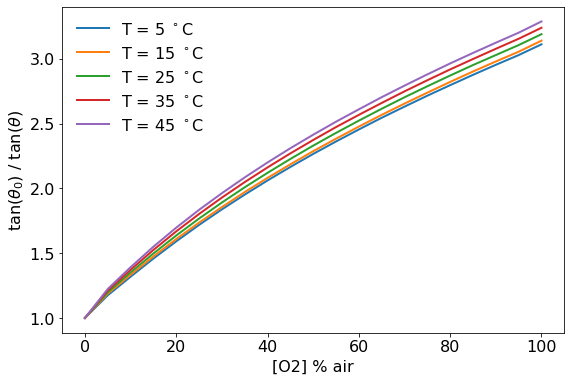

In [303]:
fig = plt.figure(figsize=(9,6))
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16, frameon=False)
plt.xlabel('[O2] % air', fontsize = 16)
plt.ylabel(r'$\tan (\theta_0) \ / \ \tan (\theta)$ ', fontsize = 16)
#plt.ylim(0,90)
df3sorted = df3.sort_values('T')
for i in np.arange(0,df3.shape[0],2):
    xx,yy = zip(*sorted(zip(df3sorted.iloc[i]['O2x'][0],df3sorted.iloc[i]['data'][0])))
    plt.plot(xx,np.tan(yy[0]*np.pi/180.0) /np.tan(np.array(yy)*np.pi/180.0)  , linewidth = 2, label = 'T = ' + str(df3sorted['T'].iloc[i]) + ' $^\circ$C')
plt.legend(fontsize = 16, frameon=False)
plt.show()
fig.savefig('../paper/expdata4.eps')
fig.savefig('../paper/expdata4.svg')
fig.savefig('../paper/expdata4.png')

# Plot expdata2

W0117 14:02:45.396734 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0117 14:02:45.397303 4624096704 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


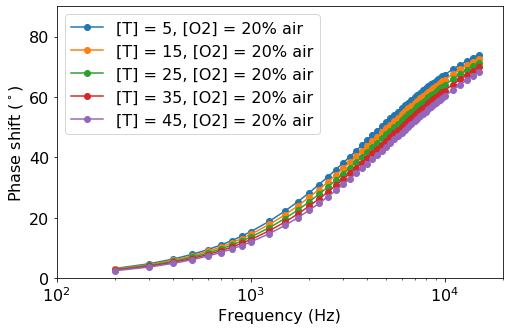

In [30]:
fig = plt.figure(figsize = (8,5))
plt.plot(x,-df_21, marker= 'o', label = '[T] = 5, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_22, marker= 'o', label = '[T] = 15, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_23, marker= 'o', label = '[T] = 25, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_24, marker= 'o', label = '[T] = 35, [O2] = '+str(OXY)+'% air')
plt.plot(x,-df_25, marker= 'o', label = '[T] = 45, [O2] = '+str(OXY)+'% air')
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16)
plt.ylim(0, 90)
plt.xlim(100, 20000)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase shift ($^\circ$)', fontsize = 16)
plt.xscale('log')
fig.savefig('../paper/expdata2.eps')

# Subtracting the reference (AT THE MOMENT WE SKIP THIS STEP)

**In clarification with Michi from Francesca**

Now let's first subtract the reference.

In [ ]:
# for i in range (train_data_np.shape[0]):
#  train_data_np[i] = train_data_np[i] - ref_data

# Options for saving data for training

1. $\theta / \ 90$
2. $\theta / \theta_0$
3. $\tan \theta / \tan \theta_0$
4. $\theta_0 / \theta$

# Case 1- $\theta / 90$

In [139]:
train_data_np_norm = np.zeros(train_data_np.shape)
train_data_np_norm = train_data_np / 90.0

# Save the data

## Save data

In [140]:
np.savetxt(root_folder + 'train_data1.csv', train_data_np_norm, delimiter=',')

## Save targets

In [141]:
np.savetxt(root_folder + 'train_targets1.csv', train_targets_np, delimiter=',')

# Case 2- $\theta / \theta_0$

In [30]:
train_data_norm = []

for i in range (train_data_np.shape[0]):
  # for each values of T and O2 identify the right dataset

  T_ = train_targets_np[i][0]
  zero_ = df_zero[(df_zero['T'] == T_)].iloc[0]
  

  #res_ = np.divide(train_data_np[i], zero_['average'])
  res_ = np.divide(train_data_np[i], zero_['average'])
  
  train_data_norm.append(res_)
  

train_data_norm_np = np.array(train_data_norm)

# Save the data

## Save data

In [31]:
np.savetxt(root_folder + 'train_data2.csv', train_data_norm_np, delimiter=',')

## Save targets

In [32]:
np.savetxt(root_folder + 'train_targets2.csv', train_targets_np, delimiter=',')

# Case 3 - $\tan \theta / \tan \theta_0$

In [27]:


train_data_norm = []

for i in range (train_data_np.shape[0]):
  # for each values of T and O2 identify the right dataset

  T_ = train_targets_np[i][0]
  zero_ = df_zero[(df_zero['T'] == T_)].iloc[0]
  

  #res_ = np.divide(train_data_np[i], zero_['average'])
  res_ = np.divide(np.tan(train_data_np[i]*np.pi/180.0), np.tan(zero_['average']*np.pi/180.0))
  
  train_data_norm.append(res_)
  

train_data_norm_np = np.array(train_data_norm)

# Save the data

## Save data

In [28]:
np.savetxt(root_folder + 'train_data3.csv', train_data_norm_np, delimiter=',')

## Save targets

In [29]:
np.savetxt(root_folder + 'train_targets3.csv', train_targets_np, delimiter=',')

# Case 4 - $\theta_0 / \theta$

# diving by the values at 0 %

In [132]:
train_data_norm = []

for i in range (train_data_np.shape[0]):
  # for each values of T and O2 identify the right dataset

  T_ = train_targets_np[i][0]
  zero_ = df_zero[(df_zero['T'] == T_)].iloc[0]
  

  #res_ = np.divide(train_data_np[i], zero_['average'])
  res_ = np.divide(zero_['average'], train_data_np[i])
  
  train_data_norm.append(res_)
  

train_data_norm_np = np.array(train_data_norm)

Now let's print one to check how it looks like.

# Save the data

## Save data

In [133]:
np.savetxt(root_folder + 'train_data4.csv', train_data_norm_np, delimiter=',')

## Save targets

In [134]:
np.savetxt(root_folder + 'train_targets4.csv', train_targets_np, delimiter=',')

# Frequency values

In [195]:
x

array([  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.])